Neste notebook estudamos o comportamento do integrando da função de densidade da natalidade, $\beta$, além de suas derivadas $\beta'$ e $\beta''$, que foram usadas no modelo. Ou seja, dada a função

$$\beta(x) = \int\phi(u)\Big[\frac{1}{N(u)}\int\phi(v)A(u,v)N_{(u+v)/2,\sigma_f}(x)dv \Big]du$$

estudaremos, 

$$\phi(u)\Big[\frac{1}{N(u)}\int\phi(v)A(u,v)N_{(u+v)/2,\sigma_f}(x)dv \Big]du.$$


In [28]:
#Importando bibliotecas

%matplotlib inline
import numpy as np
from numpy import sin, exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint, quad, dblquad
from scipy.integrate import trapezoid as trapz
from scipy.interpolate import CubicSpline
import warnings

In [8]:
#Parâmetros

xmax = 3
num = 801
sigmaf = 1e-3
sigmaA = 1e-2
b0 = 1
s = 0.1
w = 2
d0 = 0
VM = 0
qtdz = 2

#Tempo
temp = 50
t = np.arange(0, temp, 5)

#Condição inicial
# n-0 f1-1 f2-2 V1-3 V2-4 z1-5 z2-6
x0 = np.array([1., 2/3, 1/3, 0.01, 0.01, 0.5, -0.5])

#Gerando uma grade
u = np.linspace(-xmax, xmax, num)
x = np.linspace(-xmax, xmax, num)
grid = np.meshgrid(x, u)

In [ ]:
#Definição de funções

def phi(x, cond):
    soma = 0
    for i in range(qtdz):
        soma += cond[i+1]*1/(np.sqrt(2*np.pi*cond[i+1+qtdz]))* \
                np.exp(-(x-cond[i+1+2*qtdz])**2/(2*cond[i+1+qtdz]))
    return cond[0]*soma


def N(u, cond):
    soma = 0
    for i in range(qtdz):
        f = cond[1+i]
        V = cond[1+i+qtdz]
        z = cond[1+i+2*qtdz]
        soma += (f * np.exp((2*V*(u - z)**2/(2*V + sigmaA**2) - u**2 + 2*u*z - z**2) / 
                            sigmaA**2) / np.sqrt(2*V + sigmaA**2) / (2 * np.pi * sigmaA))
    return soma * cond[0] + np.finfo(np.float64).smallest_normal

def intdentro(x, u, cond):
    soma = 0
    for i in range(qtdz):
        f = cond[1+i]
        V = cond[1+i+qtdz]
        z = cond[1+i+2*qtdz]
        soma += ( f * np.sqrt(4*V + 2*sigmaA**2) * np.exp(2*sigmaf**2*(-4*V*u + 4*V*x - sigmaA**2*u +
                2*sigmaA**2*x - sigmaA**2*z)**2/(V**2*sigmaA**4 + 8*V**2*sigmaA**2*sigmaf**2 +
                4*V*sigmaA**4*sigmaf**2) - 4*u**2/sigmaA**2 + 8*u*x/sigmaA**2 - 4*x**2/sigmaA**2 -
                u**2/(2*V) + 2*u*x/V - u*z/V - 2*x**2/V + 2*x*z/V - z**2/(2*V)) /
                (2*np.pi**(3/2)*sigmaA*np.sqrt(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 
                16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)) )
    return soma * cond[0]

def dintdentro(x, u, cond):
    from numpy import sqrt, exp, pi
    soma = 0
    for i in range(qtdz):
        f = cond[1+i]
        V = cond[1+i+qtdz]
        z = cond[1+i+2*qtdz]
        soma += f * (sqrt(2)*(2*V + sigmaA**2)**(3/2)*(4*V*u + sigmaA**2*(u - 2*x + z))*
                     (4*V*u - 4*V*x + sigmaA**2*(u - 2*x + z))*
                     exp(-(4*V*(u**2 - 2*u*x + x**2) + sigmaA**2*
                           (u**2 - 4*u*x + 2*u*z + 4*x**2 - 4*x*z + z**2)/2 -
                           2*sigmaf**2*(4*V*u - 4*V*x + sigmaA**2*(u - 2*x + z))**2/
                           (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))/
                         (V*sigmaA**2))/(pi**(3/2)*sigmaA*(4*V*u + sigmaA**2*u -
                                    2*sigmaA**2*x + sigmaA**2*z)*(2*V**2*sigmaA**2 + 
                                    16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 
                                    4*sigmaA**4*sigmaf**2)**(3/2)))
    return cond[0] * soma

def d2intdentro(x, u, cond):
    from numpy import sqrt, exp, pi
    soma = 0
    for i in range(qtdz):
        f = cond[1+i]
        V = cond[1+i+qtdz]
        z = cond[1+i+2*qtdz]
        soma += f * ((4*V*u + sigmaA**2*(u - 2*x + z))*((2*V + sigmaA**2)**2*
                    (V*sigmaA**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 
                     4*sigmaf**2*(-4*V*u + 4*V*x - sigmaA**2*(u - 2*x + z))**2) - 
                    (2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 
                    4*sigmaA**4*sigmaf**2)**2)*
                     sqrt(4*V**2*sigmaA**2 + 32*V**2*sigmaf**2 + 2*V*sigmaA**4 + 32*V*sigmaA**2*sigmaf**2 + 
                          8*sigmaA**4*sigmaf**2)*exp((4*V*(-u**2 + 2*u*x - x**2) + 
                            sigmaA**2*(-u**2 + 4*u*x - 2*u*z - 4*x**2 + 4*x*z - z**2)/2 + 
                            2*sigmaf**2*(-4*V*u + 4*V*x - sigmaA**2*(u - 2*x + z))**2/
                            (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))/
                            (V*sigmaA**2))/(2*pi**(3/2)*sigmaA*sigmaf**2*(2*V + sigmaA**2)**(5/2)*
                            (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**3*
                            (4*V*u + sigmaA**2*u - 2*sigmaA**2*x + sigmaA**2*z)))
    return cond[0] * soma

## Integrando de $\beta$

In [9]:
#Definindo o integrando e calculando
def pcolor_integrando_beta(x, u, cond):
    return phi(u, cond) / N(u, cond) * intdentro(x, u, cond)

y_pcolor = pcolor_integrando_beta(grid[0], grid[1], x0)

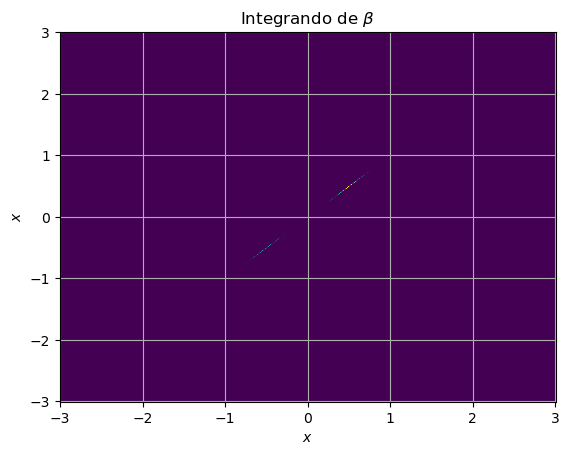

In [27]:
#Plotando
plt.pcolor(grid[0], grid[1], y_pcolor)
plt.title(r"Integrando de $\beta$")
plt.xlabel(r"$x$")
plt.ylabel(r"$x$")
plt.grid()

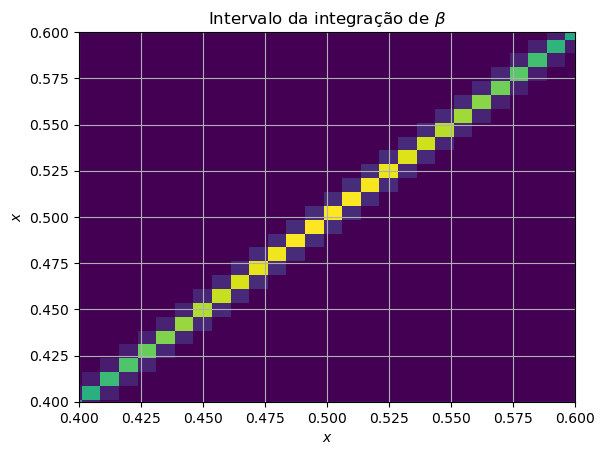

In [14]:
#Plotando com zoom
plt.pcolor(grid[0], grid[1], y_pcolor)
plt.title(r"Intervalo da integração de $\beta$")
plt.xlabel(r"$x$")
plt.ylabel(r"$x$")
plt.xlim((0.5-0.1, 0.5+0.1))
plt.ylim((0.5-0.1, 0.5+0.1))
plt.grid()

## Integrando de $\beta'$

In [25]:
#Definindo o integrando da derivada e calculando
def pcolor_integrando_dbeta(x, u, cond):
    return phi(u, cond) / N(u, cond) * dintdentro(x, u, cond)
z = pcolor_integrando_dbeta(grid[0], grid[1], x0)

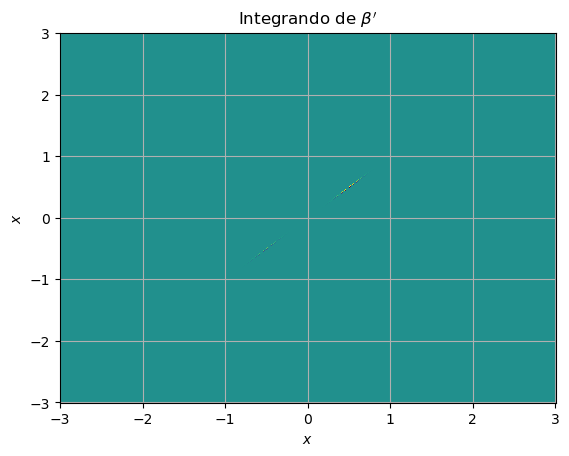

In [20]:
#Plotando
plt.pcolor(grid[0], grid[1], z)
plt.title(r"Integrando de $\beta'$")
plt.xlabel(r"$x$")
plt.ylabel(r"$x$")
plt.grid()

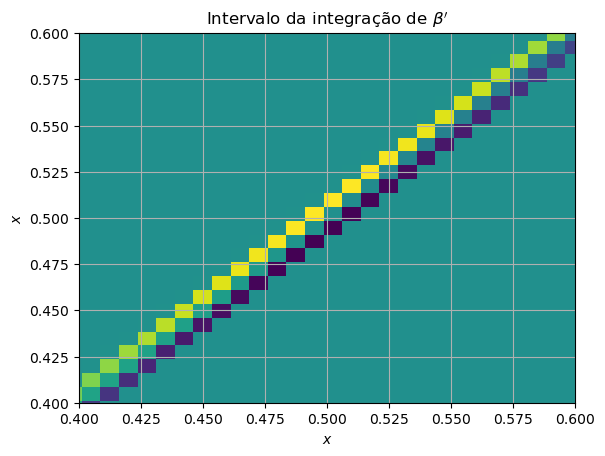

In [21]:
#Plotando com zoom
plt.pcolor(grid[0], grid[1], z)
plt.title(r"Intervalo da integração de $\beta'$")
plt.xlabel(r"$x$")
plt.ylabel(r"$x$")
plt.xlim((0.5-0.1, 0.5+0.1))
plt.ylim((0.5-0.1, 0.5+0.1))
plt.grid()

## Integrando de $\beta''$

In [23]:
#Definindo o integrando da segunda derivada e calculando
def pcolor_integrando_d2beta(x, u, cond):
    return phi(u, cond) / N(u, cond) * d2intdentro(x, u, cond)
z2 = pcolor_integrando_d2beta(grid[0], grid[1], x0)

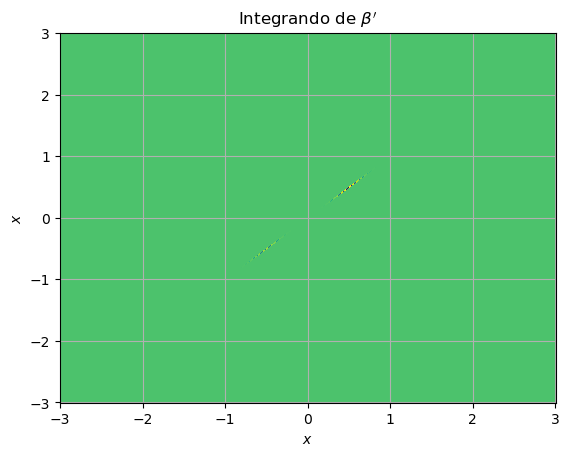

In [24]:
#Plotando
plt.pcolor(grid[0], grid[1], z2)
plt.title(r"Integrando de $\beta''$")
plt.xlabel(r"$x$")
plt.ylabel(r"$x$")
plt.grid()

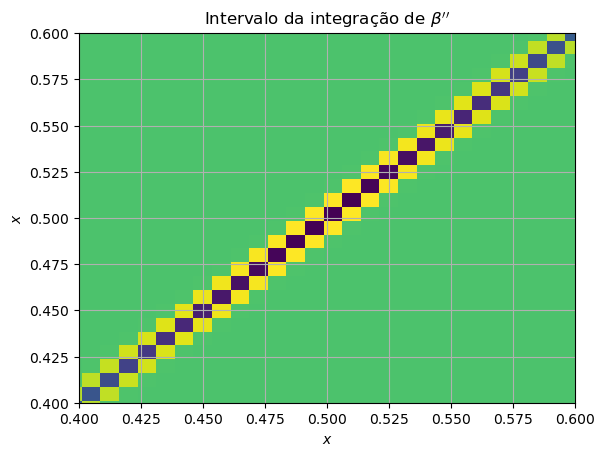

In [26]:
#Plotando com zoom
plt.pcolor(grid[0], grid[1], z2)
plt.title(r"Intervalo da integração de $\beta''$")
plt.xlabel(r"$x$")
plt.ylabel(r"$x$")
plt.xlim((0.5-0.1, 0.5+0.1))
plt.ylim((0.5-0.1, 0.5+0.1))
plt.grid()